# Introduction to PipeLine

The easiest way to understand MiniPipe is to dive into some examples. So let's first look at a simple toy example of a mini-batch pipeline. This example is just to demonstrate the basic functionality of MiniPipe. We'll get to some real-world applications later on. 

Most machine learning pipeline will have at least three stages: load, transform and train. In this example we'll simulate these three stages with these simple functions

In [1]:
import time

# 'loads' data
def loader(n):
    for i in range(n):
        time.sleep(0.5)
        yield i

# performs square transformation to data        
def trans(x):
    time.sleep(1)
    return x**2

# 'saves' data
def save(x):
    time.sleep(0.5)
    print('x = {}'.format(x))

The first function, `loader`, returns a python generator, which we'll use to generate our "data". I've added a delay of 0.5s into the generator to simulate loading time. The next function `transform` is a simple transformation on our data (squares the input), which takes twice as long (1s) as loading. Finally `save` simply prints our data to stdout, also taking 0.5s to simulate saving time.

Of course in this simple example we can fit all the “data” into memory, but lets pretend like that's not the case. We need to load one chunk of data at a time, where each data chunk is returned with the `next(loader())` method. 

## Serial Pipeline (without MiniPipe)

Lets setup a serial pipeline without MiniPipe, where we get the data, transform it and then save it one batch at a time. We'll use jupyter's %%timeit magic cell to time execution time. 

In [2]:
%%timeit -n 1 -r 1

# initialize loader
ldr = loader(10)

# run pipeline
for data in ldr: 
    x = trans(data)
    save(x)

x = 0
x = 1
x = 4
x = 9
x = 16
x = 25
x = 36
x = 49
x = 64
x = 81
20 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The for loop calls the `next(lrd)` method 10 times sequentially, each time applying `transform` followed by `save`. As expected the execution time takes about 20s since each iteration takes a total of 2s (0.5s + 1s + 0.5s) and it's repeated 10 times.

## MiniPipe: Pipeline Parallel

Now lets see what the same pipeline looks like in MiniPipe.

In [2]:
from minipipe import Source, Transform, Sink

@Source
def loader(n):
    for i in range(n):
        time.sleep(0.5)
        yield i
        
@Transform
def trans(x):
    time.sleep(1)
    return x**2

@Sink
def save(x):
    time.sleep(0.5)
    print('x = {}'.format(x))

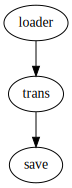

In [3]:
from minipipe import Pipeline

# initialize loader
ldr = loader(10)

# build pipeline
pline = Pipeline()
pline.add(ldr)
pline.add(trans)
pline.add(save) 
pline.build()

# draw pipeline
pline.diagram()

If you've used the Keras Sequential API this will look familiar to you. MiniPipe has three basic types of pipe segments: Sources, Transforms and Sinks. Each has one requires an argument called functor. For Sources functors must always be an uninitialized generator, while for Sinks and Transforms functors can be either a function or a class (with a `run` method). There's also an additional pipe segment called a Regulator which accepts coroutines, which will be discuss later. 

Sources pass data downstream, Sinks accept data from upstream and Transforms do both. In the PipeLine API pipe segments are connected by adding them to an initialized `PipeLine` and then calling the `PipeLine.build` method. 

We can inspect the pipeline graph with the `PipeLine.diagram` method (requires graphviz) to make sure it looks as expected. 

Looks good. Now we can run the pipeline; let's again time it as before.

In [4]:
%%timeit -n 1 -r 1
pline.run()

x = 0
x = 1
x = 4
x = 9
x = 16
x = 25
x = 36


2020-02-09 18:00:39,022 - INFO - loader - End of stream


x = 49


2020-02-09 18:00:40,023 - INFO - loader - Local termination


x = 64


2020-02-09 18:00:41,025 - INFO - trans - Local termination


x = 81


2020-02-09 18:00:41,528 - INFO - save - Local termination


11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We see from the logging (which can be set in the `PipeLine.build` method) where each pipe segment shutdown. When the end of stream was reached Source shutdown, followed by Transform and Sink. 

The execution time is now 11s instead of 20s. That's because each pipe segments executes on it's own thread/process allowing for parallel execution. Of course dependent nodes still have to wait for data to be passed downstream, but once data is passed the node can start on the next batch without waiting for the full pipeline to be executed. Thus we expect the total time to be 0.5s (initial load) + 10 x (1s) + 0.5s (final save) = 11s. 

By default MiniPipe will place each pipe segment on its own process. Each process runs independently in an asynchronous fashion. MiniPipe is an API built on top of Python's Multiprocessing library. 

There is no limit to the number of processes you can run, however you are limited by the number of physical cores on your machine. For computation heavy pipelines bound to the CPU you may see performance degradation if the number of pipe segments exceed the number of physical cores. On the other hand, I/O processes such as loading, or computation that's bound to the GPU such as training, this should be less of an issue. 

## MiniPipe: Horizontal Scaling

Since `Transform` takes twice as long as `Loader` and `Save` we can additionally speed things up by by increasing the number of Transform processes. Minipipe is designed for this type of horizontal parallelization as well.

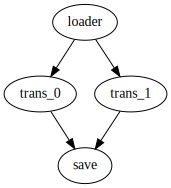

In [5]:
# initialize loader
ldr = loader(10)

# build pipeline
pline = (Pipeline()
         .add(ldr)                 # .add returns self
         .add([trans, trans])      # so you can chain them 
         .add(save)                # like this 
         .build())                 # and build too 

# draw pipeline
pline.diagram()                    # this does not chain

We setup the pipeline exactly as before, except now when we add Transform to the pipeline we reserve two processes with the `n_processes` argument. 

Now lets look at the pipeline graph.

We see there are two separate Transform processes, but it's somewhat unclear what happens to the data after Source. To understand what's happening here we have to introduce the concept of a Stream.

A Stream is a multiprocessing queue that holds the data while processes are busy. Each pipe segment is connected to a Stream. To see the Streams in the graph diagram along with the pipe segments you just need to set the `draw_streams` argument to true. 

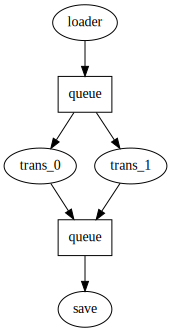

In [6]:
pline.diagram(draw_streams=True)

We see that `loader` puts data on its downstream queue `stream_0` while both `Transform_0` and `Transform_1` get data from that same queue. This allows the two Transform processes to executing asynchronously. The first available Transform process will take the data, so in this graph the order of data chunks in not necessarily preserved. 

Now lets see how long this pipeline takes.

In [7]:
%%timeit -n 1 -r 1
pline.run()

x = 0
x = 1
x = 4
x = 9
x = 16
x = 25


2020-02-09 18:00:56,761 - INFO - loader - End of stream


x = 36


2020-02-09 18:00:57,264 - INFO - loader - Local termination


x = 49


2020-02-09 18:00:57,300 - INFO - trans_0 - Local termination


x = 64


2020-02-09 18:00:57,803 - INFO - trans_1 - Local termination


x = 81


2020-02-09 18:00:58,306 - INFO - save - Local termination


6.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We see it takes just over 6.5s as expected, about 1/3rd of the original execution time. 

At this point the only way to speed things up further is to introduce parallel load processes. This can be done by using two separate Sources each with their own generator function. However this cannot be done with the PipeLine API since it only allows for sequential pipelines. In the next section we'll introduce the PipeSystem API, which allows for general graph structures. 

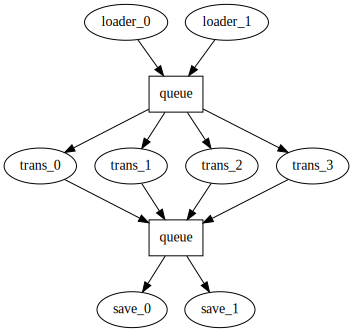

In [9]:
@Source
def loader(start, stop, step):
    for i in range(start, stop, step):
        time.sleep(0.5)
        yield i

# initialize loader
ldr1 = loader(0, 10, 2) # these Sources iterate over 
ldr2 = loader(1, 10, 2) # different values 


# build pipeline
pline = (Pipeline()
         .add([ldr1, ldr2]) # two different Sources
         .add([trans]*4)    # you may use list multiplication  
         .add([save]*2)     # to dulplicate the same pipes             
         .build())                 

# draw pipeline
pline.diagram(True)                    

In [10]:
%%timeit -n 1 -r 1
pline.run()

x = 0
x = 1
x = 4
x = 9


2020-02-09 18:01:13,368 - INFO - loader_0 - End of stream
2020-02-09 18:01:13,371 - INFO - loader_1 - End of stream


x = 16
x = 25


2020-02-09 18:01:13,881 - INFO - trans_2 - Local termination


x = 36


2020-02-09 18:01:14,381 - INFO - loader_0 - Local termination


x = 49


2020-02-09 18:01:14,381 - INFO - trans_3 - Local termination
2020-02-09 18:01:14,419 - INFO - loader_1 - Local termination
2020-02-09 18:01:14,419 - INFO - trans_0 - Local termination


x = 64


2020-02-09 18:01:14,884 - INFO - save_0 - Local termination


x = 81


2020-02-09 18:01:14,921 - INFO - save_1 - Local termination
2020-02-09 18:01:14,884 - INFO - trans_1 - Local termination


4.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
